# Solve NFW equations with lenstronomy

In [22]:
import numpy as np
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Profiles.nfw import NFW
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from astropy.cosmology import FlatLambdaCDM

In [42]:
cosmology = FlatLambdaCDM(H0=70, Om0=0.3)  # Example values
# Lens and source redshift
z_l = 1
z_s = 2
lens_cosmo = LensCosmo(z_lens=z_l, z_source=z_s, cosmo=cosmo)

# NFW profile parameters
M200 = 1e15  # Solar masses

# Empirical mass-concentration relation (Dutton & Macciò 2014)
def concentration(M200, z):
    A = 5.71
    B = -0.084
    C = -0.47
    c200 = A * (M200 / 1e12)**B * (1 + z)**C
    return c200

# Calculate concentration parameter
c200 = concentration(M200, z_l)

# Convert M200 to lensing parameters
Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=M200, c=c200)

rho0, Rs, c, r200, M200 = lens_cosmo.nfw_angle2physical(Rs_angle=Rs_angle, alpha_Rs=alpha_Rs)

In [68]:
lens_model_list = ['NFW']
lens_model = LensModel(lens_model_list)
kwargs_nfw = [{'Rs': Rs, 'alpha_Rs': alpha_Rs, 'center_x': 0, 'center_y': 0}]

In [80]:
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
solver = LensEquationSolver(lens_model)
x_source, y_source = 9, 9
x_image, y_image = solver.image_position_from_source(
                sourcePos_x=x_source,
                sourcePos_y=y_source,
                kwargs_lens=kwargs_nfw)
mag = lens_model.magnification(x_image, y_image, kwargs_nfw)

print(f"Source position: ({x_source}, {y_source})")
print(f"Image position: ({x_image}, {y_image})")
print(f"Magnification: {mag}")

## uncomment to test for multiple source positions
# x_source_arr, y_source_arr = np.linspace(0, 10, 100), np.linspace(0, 10, 100)
# x_image_arr, y_image_arr = [], []
# mag_arr = []
# for x_source, y_source in zip(x_source_arr, y_source_arr):
#     x_image, y_image = solver.image_position_from_source(
#                     sourcePos_x=x_source,
#                     sourcePos_y=y_source,
#                     kwargs_lens=kwargs_nfw)
#     x_image_arr.append(x_image)
#     y_image_arr.append(y_image)
#     mag = lens_model.magnification(x_image, y_image, kwargs_nfw)
#     mag_arr.append(mag)


Source position: (9, 9)
Image position: ([-0.92099628 -0.25045456], [-0.92099628 -0.25045456])
Magnification: [-0.03977996  0.00336396]


In [98]:
mag[0]*100

-3.9779963373285367

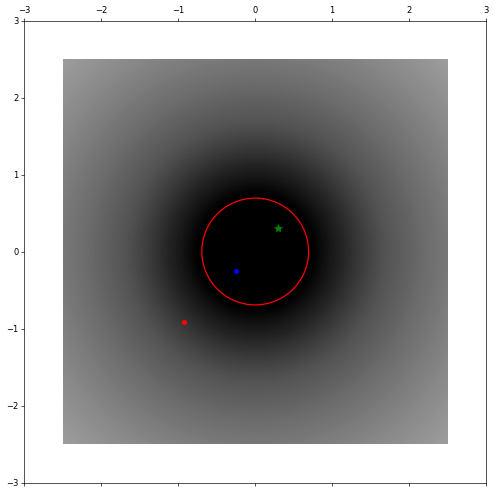

In [104]:
from lenstronomy.Plots import lens_plot

fig, ax = plt.subplots(figsize=(10,10),dpi=60)
beta_ra, beta_dec = 0.3,0.3
lens_plot.lens_model_plot(ax, 
    lensModel=lensModel, 
    kwargs_lens=kwargs_nfw, 
    sourcePos_x=beta_ra, 
    sourcePos_y=beta_dec, 
    point_source=True,
    with_caustics=True,
    fast_caustic=True,
    coord_inverse=True,
)
                      
# image
# add point size to make it visible
plt.plot(x_image[0], y_image[0],marker='.',ls='None', color='r', markersize=10, label='Image 1')
plt.plot(x_image[1], y_image[1],marker='.',ls='None', color='b', markersize=10, label='Image 2')

# source
plt.plot(beta_ra, beta_dec,marker='*',ls='None', color='g', markersize=10, label='Source')

ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
plt.show()